In [10]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from scipy.linalg import LinAlgError, solve

Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_2_list_adapted = None

# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)

hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.366e-29     # Dipole moment between states (|1> and |3>) (C·m)
mu_23 = 1.058e-29     # Dipole moment between states (|2> and |3>) (C·m)
c = 3e8

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 0.5 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 0.5 * Gamma3   # Decay from level 3 to level 2 (MHz)

# in the ideal case, there will be no Gamma12 and Gamma21 since there will be minimum collision 
# therefore there will be minimum population transfer between the two ground states
Gamma12 = Gamma21 = 0    # Decay rates between levels 1 and 2 (MHz)

# Decoherence terms
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
# In this case is the gamma12 also zero?
gamma12 = 1e-5 * Gamma3   # Decoherence rate between ground states (MHz)

w_1 = 2 * np.pi * 3.771120414e14
w_2 = 2 * np.pi * 3.771052067e14
k_1 = w_1 / 3e8
k_2 = w_2 / 3e8
L = 0.02        # Length in meters

OD_0 = 50
N = OD_0 / ((4 * np.pi * mu_13**2 * L) / (Gamma3 * 10**6 * hbar * epsilon_0 * 795e-9))

print("Atomic Density (OD0={:.2f}) = {:.2e}".format(OD_0, N))
w_p = 2 * np.pi * 3e8 / 795e-9
k_0 = w_p / 3e8

Atomic Density (OD0=50.00) = 2.98e+16


### Figure 2c and 2d

For figure 2c, we want to plot the EIT transmission spectrum in order to explore the effects of detuning. The transmission spectrum of a few different laser 2 powers would be plotted, and respectively, fig 2d would contain the transmission of laser 1 with respect to laser 2, with different detuning on the first laser. In this case, we would like to have a reasonable gamma12 value. 

For 2d, we want to have two sets of axis, one for the transmission, and other for the power of the lasers.

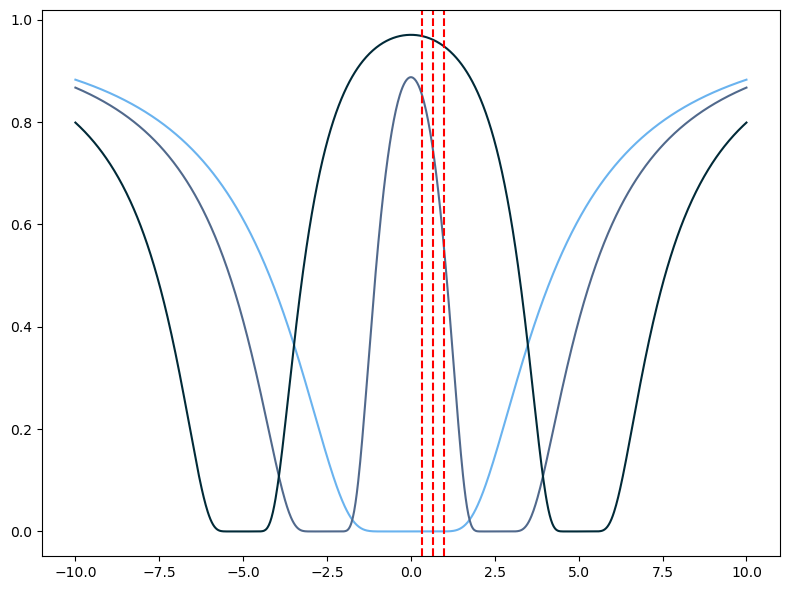

In [11]:
gamma12 = 0.03 * Gamma3

# =============================================================================
# Function to compute Transmission vs. probe detuning (for one dimensionless Omega_c)
# =============================================================================
def transmission_vs_detuning_dimless(
    Om_p_mhz=1.0,
    Om_c_dimless=1.0,
    delta_c_mhz=0.0,
    detuning_min=-50.0,
    detuning_max=50.0,
    num_points=1000
):
    """
    Computes the transmission (e^-OD) for a given dimensionless coupling Rabi frequency
    (Om_c_dimless = Om_c / Gamma3), scanning over probe detuning in MHz.
    """
    # Convert dimensionless Om_c to actual MHz
    Om_c_mhz = Om_c_dimless * Gamma3

    delta_p_list = np.linspace(detuning_min, detuning_max, num_points)
    T_list = []

    for dp in delta_p_list:
        numerator = 2 * Om_p_mhz * (dp - delta_c_mhz + 1j * gamma12)
        denominator = (
            Om_c_mhz * np.conjugate(Om_c_mhz)
            - 4 * (dp - delta_c_mhz + 1j * gamma12) * (dp + 1j * gamma13)
        )
        rho31 = numerator / denominator

        # Susceptibility chi
        chi = (2 * N * rho31 * mu_13**2) / (epsilon_0 * hbar * (Om_p_mhz * 1e6))

        # Optical Depth (OD)
        OD = k_1 * np.imag(chi) * L  # Possibly /2 depending on definitions

        # Transmission (e^-OD)
        T_list.append(np.exp(-OD))

    return delta_p_list, np.array(T_list)

w0 = 71e-6          # In m
# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))

# =============================================================================
# Plot function to compare multiple dimensionless Omega_c values with a 
# partially-clamped (0.2 -> 0.8) gradient colormap
# =============================================================================
def plot_transmission_multi_OmC_dimless(
    Om_p_mhz,
    Om_c_values_dimless,
    delta_c_mhz,
    detuning_min=-50.0,
    detuning_max=50.0,
    num_points=1000
):
    """
    For a fixed probe Rabi frequency (Om_p_mhz) and a list of *dimensionless*
    coupling Rabi frequencies (Om_c_values_dimless = Om_c / Gamma3),
    plot Transmission vs. probe detuning for each coupling on the same figure,
    using a gradient colormap that excludes the palest/lightest tones.
    """
    plt.figure(figsize=(8, 6))

    # Choose a colormap
    cmap = plt.cm.PuBu
    # If you're plotting exactly 3 curves, pre-define your 3 desired colors:
    custom_colors = ["#6ab3ef", "#51698c", "#012a38"]  # bright, medium, dark

    # Number of different curves
    n_curves = len(Om_c_values_dimless)

    # Define how much of the colormap range to skip
    color_min, color_max = 0.2, 0.8  # Adjust to exclude very faint and very dark

    for idx, Om_c_dimless in enumerate(Om_c_values_dimless):
        # Fraction from 0 to 1 among the curves
        color_fraction = idx / (n_curves - 1) if n_curves > 1 else 0.5
        # Map this fraction into [color_min, color_max]
        adjusted_fraction = color_min + color_fraction * (color_max - color_min)
        line_color = cmap(adjusted_fraction)

        delta_p_list, T_list = transmission_vs_detuning_dimless(
            Om_p_mhz=Om_p_mhz,
            Om_c_dimless=Om_c_dimless,
            delta_c_mhz=delta_c_mhz,
            detuning_min=detuning_min,
            detuning_max=detuning_max,
            num_points=num_points
        )
        line_color = custom_colors[idx]
        # Convert probe detuning from MHz to dimensionless delta_p / Gamma3
        delta_p_scaled = delta_p_list / Gamma3

        # Plot, specifying 'color=line_color'
        label_str = fr"$\Omega_2 = {Om_c_dimless:.2f} \Gamma_3$"
        plt.plot(delta_p_scaled, T_list, label=label_str, color=line_color)

    # plt.title(
    #     fr"Transmission vs. Field 1 Detuning ($\delta_1/\Gamma_3$)\n"
    #     fr"(Probe: $\Omega_1={Om_p_mhz}$ MHz, $\delta_2={delta_c_mhz}$ MHz)"
    # )
    # plt.xlabel(r"Probe Detuning $\delta_1 / \Gamma_3$")
    # plt.ylabel("Transmission (e$^{-\mathrm{OD}}$)")
    # plt.legend()
    plt.tight_layout()
    plt.axvline(x=1/3, color='red', linestyle='--', linewidth=1.5)
    plt.axvline(x=2/3,    color='red', linestyle='--', linewidth=1.5)
    plt.axvline(x=1.0,    color='red', linestyle='--', linewidth=1.5)

    # Save as SVG or EPS
    plt.savefig("2c.svg", format="svg")  # For SVG format
    plt.savefig("2c.eps", format="eps")  # For EPS format
    plt.show()

# =============================================================================
# Example usage
# =============================================================================
if __name__ == "__main__":
    # Example parameters:
    Om_p_example   = 0.001   # Probe Rabi frequency in MHz
    delta_c_example = 0.0    # Coupling detuning in MHz
    detuning_min = -10 * Gamma3
    detuning_max = 10 * Gamma3

    # Dimensionless coupling Rabi freq. values, e.g., 0.1, 1, 5
    Om_c_values_dimless = [0.01, 5.01, 10.0]

    # Generate the plot
    plot_transmission_multi_OmC_dimless(
        Om_p_mhz=Om_p_example,
        Om_c_values_dimless=Om_c_values_dimless,
        delta_c_mhz=delta_c_example,
        detuning_min=detuning_min,
        detuning_max=detuning_max,
        num_points=1000
    )


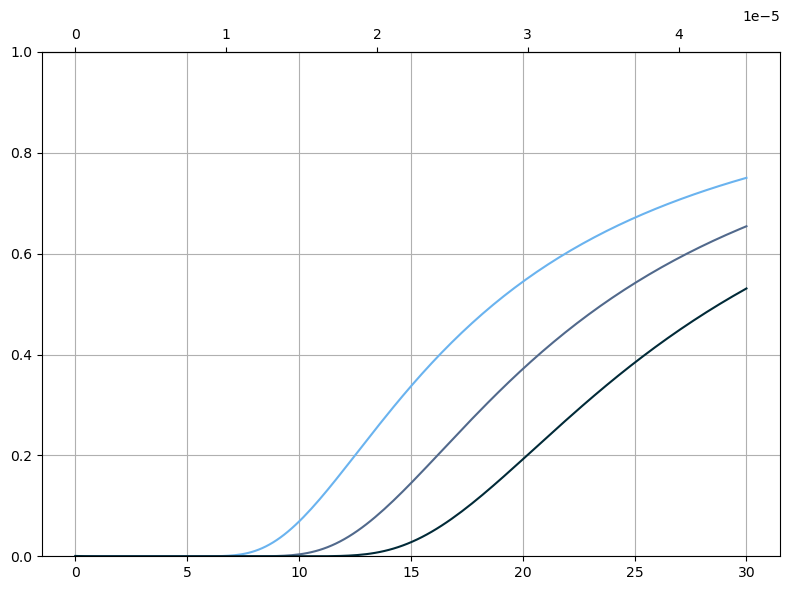

In [15]:
# =============================================================================
# Single-point function: returns Transmission for given (Om_p, Delta_1, Delta_2, Om_c)
# =============================================================================
def single_pass_transmission(Om_p_mhz, delta_1_mhz, delta_2_mhz, Om_c_mhz):
    """
    Computes the ratio |Omega_1,out|^2 / |Omega_1,in|^2 = exp(-OD)
    for a single pass, given:

      Om_p_mhz   : probe Rabi freq (MHz)
      delta_1_mhz: probe detuning (MHz)
      delta_2_mhz: coupling detuning (MHz)
      Om_c_mhz   : coupling Rabi freq (MHz)
    """
    # Numerator and denominator for rho31
    numerator = 2 * Om_p_mhz * (delta_1_mhz - delta_2_mhz + 1j * gamma12)
    denominator = (
        Om_c_mhz * np.conjugate(Om_c_mhz)
        - 4 * (delta_1_mhz - delta_2_mhz + 1j * gamma12)
              * (delta_1_mhz + 1j * gamma13)
    )
    rho31 = numerator / denominator

    # Susceptibility chi
    chi = (2 * N * rho31 * mu_13**2) / (epsilon_0 * hbar * (Om_p_mhz * 1e6))

    # Optical depth (OD)
    OD = k_1 * np.imag(chi) * L

    # Transmission = e^-OD = |Ω1,out|^2 / |Ω1,in|^2
    return np.exp(-OD)

# =============================================================================
# Main function: For various Delta_1, we vary (Omega_c^2) and plot 
# =============================================================================
def plot_omega1out_sq_vs_omega2in_sq(
    Om_p_mhz       = 0.001,
    delta_1_list_mhz = [-2.0, 0.0, 2.0],
    delta_2_mhz    = 0.0,
    Om_c_dimless_min = 0.0,
    Om_c_dimless_max = 5.0,
    num_points     = 300
):
    """
    Plots (|Omega_1,out|^2 / |Omega_1,in|^2) as a function of |Omega_2,in|^2 (dimensionless)
    for each detuning in delta_1_list_mhz.

    * Om_c_dimless = (Omega_c / Gamma3)
    * We'll scan Om_c_dimless from Om_c_dimless_min to Om_c_dimless_max
    * On the x-axis, we display (Om_c_dimless^2) = (|Omega_2,in|^2 / Gamma_3^2).

    For each Delta_1 in delta_1_list_mhz, we compute the single-pass Transmission
    at each Omega_c, and plot Transmission vs (Om_c_dimless^2).
    """
    # Prepare array of dimensionless coupling
    Om_c_dimless_array = np.linspace(Om_c_dimless_min, Om_c_dimless_max, num_points)

    # Create figure
    fig, ax1 = plt.subplots(figsize=(8,6))

    # ----- Begin color scheme changes -----
    cmap = plt.cm.Blues  # pick the "Blues" colormap
    color_min, color_max = 0.2, 0.8  # skip the palest and darkest

    n_curves = len(delta_1_list_mhz)
    # ----- End color scheme changes -----
    custom_colors = ["#6ab3ef", "#51698c", "#012a38"]
    for idx, delta_1_mhz in enumerate(delta_1_list_mhz):
        T_curve = []
        x_values = []

        for Om_c_dimless in Om_c_dimless_array:
            # Convert dimensionless to actual (MHz)
            Om_c_mhz = Om_c_dimless * Gamma3
            
            # Transmission = ratio of |Omega_1,out|^2 / |Omega_1,in|^2
            T_point = single_pass_transmission(
                Om_p_mhz, delta_1_mhz, delta_2_mhz, Om_c_mhz
            )
            T_curve.append(T_point)

            # x-axis: (Om_c / Gamma3)^2
            x_values.append(Om_c_dimless**2)

        # ----- Pick a color from the colormap, skipping the palest shade -----
        if n_curves > 1:
            fraction = idx / (n_curves - 1)
        else:
            fraction = 0.5  # fallback if only one curve

        adjusted_fraction = color_min + fraction * (color_max - color_min)
        line_color = cmap(adjusted_fraction)
        # ----- End color picking -----
        line_color = custom_colors[idx]
        label_str = fr"$\Delta_1 = {delta_1_mhz / Gamma3:.4f} \Gamma_3$"
        plt.plot(x_values, T_curve, label=label_str, color=line_color)

    # plt.title(
    #     r"$|\Omega_{1,\mathrm{out}}|^2$ vs. $|\Omega_{2,\mathrm{in}}|^2$"
    #     rf"(Probe Rabi: $\Omega_1={Om_p_mhz}$ MHz, $\Delta_2={delta_2_mhz}$ MHz)"
    # )
    # plt.xlabel(r"$|\Omega_{2,\mathrm{in}}|^2 / \Gamma_3^2$")
    # plt.ylabel(r"$\frac{|\Omega_{1,\mathrm{out}}|^2}{|\Omega_{1,\mathrm{in}}|^2}$")
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    # ax_top.set_xlabel('Input Power for $\\Omega_2$ (W)')
    # plt.ylim([0,1.3])
    # plt.xlim([0,30])
    plt.grid()
    plt.ylim(0, 1)
    plt.margins(y=0.3)  # 10% margin
    
    # plt.legend()
    plt.tight_layout()
    # Save as SVG or EPS
    plt.savefig("2d.svg", format="svg")  # For SVG format
    plt.savefig("2d.eps", format="eps")  # For EPS format
    plt.show()

# =============================================================================
# Example usage
# =============================================================================
if __name__ == "__main__":
    # Example parameters
    Om_p_example = 0.001   # Probe Rabi freq (MHz)
    delta_2_example = 0.0  # Coupling detuning (MHz)

    # We'll see how the final probe amplitude depends on coupling power 
    # for three different probe detunings: 0.0, 1.0, 5.0 MHz
    delta_1_values = [0.8 * Gamma3, 1 * Gamma3, 1.2 * Gamma3] 

    plot_omega1out_sq_vs_omega2in_sq(
        Om_p_mhz         = Om_p_example,
        delta_1_list_mhz = delta_1_values,
        delta_2_mhz      = delta_2_example,
        Om_c_dimless_min = 0.0,
        Om_c_dimless_max = np.sqrt(30),
        num_points       = 200
    )

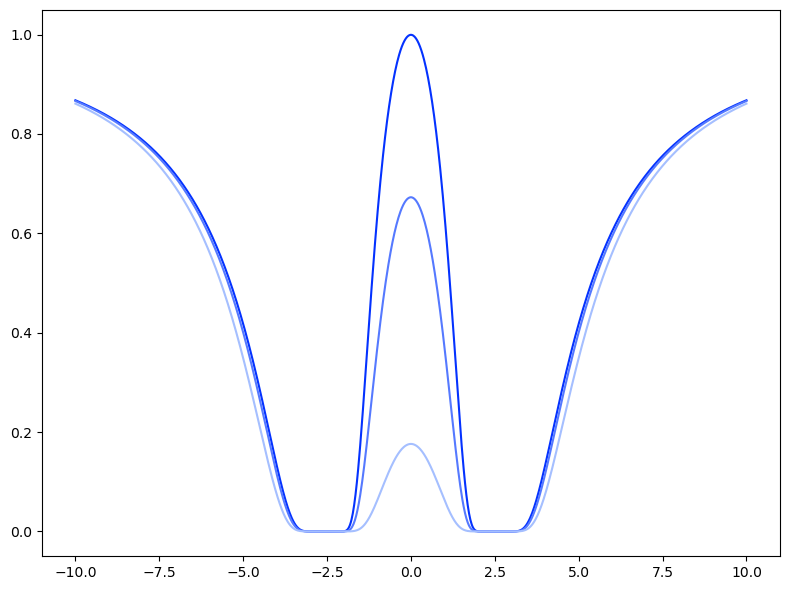

In [5]:
import matplotlib.colors as mcolors

# =============================================================================
# Function: Transmission vs detuning, for *fixed* Om_c_dimless & gamma12_mhz
# =============================================================================
def transmission_vs_detuning_dimless_g12(
    Om_p_mhz=1.0,
    Om_c_dimless=1.0,
    gamma12_mhz=0.001,   # decoherence rate between ground states (MHz)
    delta_c_mhz=0.0,
    detuning_min=-50.0,
    detuning_max=50.0,
    num_points=1000
):
    """
    Computes the transmission (e^-OD) for:
      - dimensionless coupling Rabi frequency = Om_c_dimless = Om_c / Gamma3
      - ground-state decoherence = gamma12_mhz (MHz)
      - scanning over probe detuning from detuning_min to detuning_max (MHz).
    """
    # Convert dimensionless Om_c to actual MHz
    Om_c_mhz = Om_c_dimless * Gamma3

    delta_p_list = np.linspace(detuning_min, detuning_max, num_points)
    T_list = []

    for dp in delta_p_list:
        # Build the numerator and denominator for rho31
        numerator = 2 * Om_p_mhz * (dp - delta_c_mhz + 1j * gamma12_mhz)
        denominator = (
            Om_c_mhz * np.conjugate(Om_c_mhz)
            - 4 * (dp - delta_c_mhz + 1j * gamma12_mhz) * (dp + 1j * gamma13)
        )
        rho31 = numerator / denominator

        # Susceptibility chi
        chi = (2 * N * rho31 * mu_13**2) / (epsilon_0 * hbar * (Om_p_mhz * 1e6))

        # Optical Depth (OD)
        OD = k_1 * np.imag(chi) * L  # Possibly /2 depending on definitions

        # Transmission ( = e^-OD = |Omega_1,out|^2 / |Omega_1,in|^2 )
        T_list.append(np.exp(-OD))

    return delta_p_list, np.array(T_list)

# =============================================================================
# Plot function: Sweep various gamma12_mhz, fix Om_c_dimless
# =============================================================================
def plot_transmission_multi_gamma12(
    Om_p_mhz,
    Om_c_dimless,
    gamma12_values_mhz,
    delta_c_mhz=0.0,
    detuning_min=-50.0,
    detuning_max=50.0,
    num_points=1000
):
    """
    For a fixed dimensionless coupling Rabi freq (Om_c_dimless) and a list of
    gamma12 values (MHz), plot Transmission vs. probe detuning (MHz) on the same figure.
    We'll convert the x-axis to dimensionless detuning if desired.
    """
    plt.figure(figsize=(8, 6))

    # Choose a colormap
    cmap = plt.cm.Blues

    # Number of different curves
    n_curves = len(gamma12_values_mhz)

    # Define how much of the colormap range to skip
    color_min, color_max = 0.2, 0.8
    custom_colors = ["#6ab3ef", "#51698c", "#012a38"]  # bright, medium, dark


    # Define a custom colormap from deep blue (#0432FF) to a lighter blue (#A5BFFF)
    my_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blue_gradient', ['#0432FF', '#A5BFFF'], N=3)
    # Extract three discrete colors from the colormap
    custom_colors = [my_cmap(x) for x in np.linspace(0, 1, 3)]


    for idx, gamma12_mhz in enumerate(gamma12_values_mhz):
        # Map index to a color fraction
        frac = idx / (n_curves - 1) if n_curves > 1 else 0.5
        adj_fraction = color_min + frac * (color_max - color_min)
        line_color = cmap(adj_fraction)

        # Compute Transmission vs. detuning for this gamma12
        delta_p_list, T_list = transmission_vs_detuning_dimless_g12(
            Om_p_mhz       = Om_p_mhz,
            Om_c_dimless   = Om_c_dimless,
            gamma12_mhz    = gamma12_mhz,
            delta_c_mhz    = delta_c_mhz,
            detuning_min   = detuning_min,
            detuning_max   = detuning_max,
            num_points     = num_points
        )

        # If you want dimensionless detuning on x-axis:
        delta_p_scaled = delta_p_list / Gamma3
        # but let's just keep it in MHz here:
        x_values = delta_p_scaled
        line_color = custom_colors[idx]
        label_str = fr"$\gamma_{{12}} = {gamma12_mhz/Gamma3:.4f} /\Gamma_3$"
        plt.plot(x_values, T_list, color=line_color, label=label_str)

    # plt.title(
    #     rf"Transmission vs. Probe Detuning (MHz)\n"
    #     rf"(Probe $\Omega_p={Om_p_mhz}$ MHz, $\Omega_c/\Gamma_3={Om_c_dimless}$, $\Delta_2={delta_c_mhz}$ MHz)"
    # )
    # plt.xlabel("Probe Detuning (MHz)")
    # plt.ylabel(r"Transmission ($e^{-\mathrm{OD}}$)")
    # plt.legend()
    plt.tight_layout()
    # Save as SVG or EPS
    plt.savefig("2a.svg", format="svg")  # For SVG format
    plt.savefig("2a.eps", format="eps")  # For EPS format
    plt.show()

# =============================================================================
# Example usage
# =============================================================================
if __name__ == "__main__":
    # Example: fix dimensionless coupling at Om_c_dimless=1.0 => Om_c ~ 37.7 MHz
    Om_p_example    = 0.001    # Probe Rabi freq (MHz)
    Om_c_example    = 5.0      # dimensionless => actual ~ 37.7 MHz
    delta_c_example = 0.0      # Coupling detuning (MHz)
    detuning_min    = -10 * Gamma3
    detuning_max    = 10 * Gamma3

    # Sweep gamma12 from 0.001 MHz to 1.0 MHz in log steps, for example
    gamma12_vals = [0.0001 * Gamma3, 0.1 * Gamma3, 0.45 * Gamma3] 
    # [0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1.0] (adjust # of steps as you like)

    # Or just do a few discrete values:
    # gamma12_vals = [0.001, 0.01, 0.1, 0.5]

    # Plot
    plot_transmission_multi_gamma12(
        Om_p_mhz         = Om_p_example,
        Om_c_dimless     = Om_c_example,
        gamma12_values_mhz = gamma12_vals,
        delta_c_mhz      = delta_c_example,
        detuning_min     = detuning_min,
        detuning_max     = detuning_max,
        num_points       = 1000
    )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


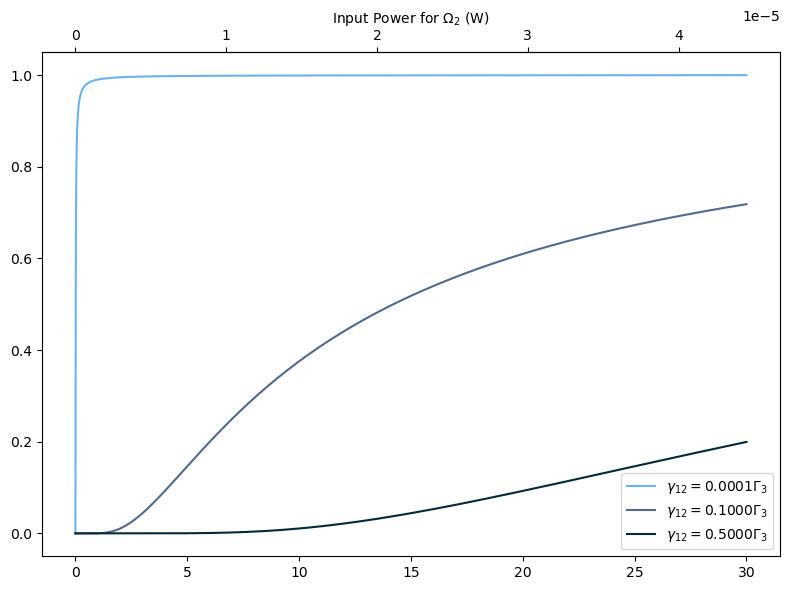

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# Single-pass transmission that accepts gamma12 as a parameter
###############################################################################
def single_pass_transmission_g12(
    Om_p_mhz, delta_1_mhz, delta_2_mhz, Om_c_mhz, gamma12_mhz
):
    """
    Computes the ratio |Omega_1,out|^2 / |Omega_1,in|^2 = exp(-OD)
    for a single pass, given:
      Om_p_mhz   : probe Rabi freq (MHz)
      delta_1_mhz: probe detuning (MHz)
      delta_2_mhz: coupling detuning (MHz)
      Om_c_mhz   : coupling Rabi freq (MHz)
      gamma12_mhz: ground-state decoherence rate (MHz)
    """
    numerator = 2 * Om_p_mhz * (delta_1_mhz - delta_2_mhz + 1j * gamma12_mhz)
    denominator = (
        Om_c_mhz * np.conjugate(Om_c_mhz)
        - 4 * (delta_1_mhz - delta_2_mhz + 1j * gamma12_mhz)
              * (delta_1_mhz + 1j * gamma13)
    )
    rho31 = numerator / denominator

    chi = (2 * N * rho31 * mu_13**2) / (epsilon_0 * hbar * (Om_p_mhz * 1e6))
    OD = k_1 * np.imag(chi) * L

    return np.exp(-OD)

w0 = 71e-6          # In m
# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))

###############################################################################
# Function: sweep gamma12 values, plot vs. (Omega_c^2) for a single Delta_1
###############################################################################
def plot_omega1out_sq_vs_omega2in_sq_gamma12(
    Om_p_mhz       = 0.001,
    delta_1_mhz    = 0.0,
    delta_2_mhz    = 0.0,
    gamma12_vals_mhz = [0.001, 0.01, 0.1],
    Om_c_dimless_min = 0.0,
    Om_c_dimless_max = 5.0,
    num_points     = 300
):
    """
    Plots (|Omega_1,out|^2 / |Omega_1,in|^2) vs. (|Omega_2,in|^2 / Gamma3^2),
    for a *single* Delta_1, but multiple gamma12 values. Each gamma12 gets its own curve.

    * We define Om_c_dimless = Om_c / Gamma3, scanning Om_c_dimless_min -> Om_c_dimless_max.
    * x-axis: (Om_c_dimless^2) = (|Omega_2,in|^2 / Gamma3^2).
    * Legend: dimensionless gamma12 (gamma12 / Gamma3).
    """
    Om_c_dimless_array = np.linspace(Om_c_dimless_min, Om_c_dimless_max, num_points)

    fig, ax1 = plt.subplots(figsize=(8,6))
    cmap = plt.cm.Blues
    color_min, color_max = 0.2, 0.8
    n_curves = len(gamma12_vals_mhz)
    custom_colors = ["#6ab3ef", "#51698c", "#012a38"]  # bright, medium, dark

    for idx, g12_mhz in enumerate(gamma12_vals_mhz):
        T_curve = []
        x_values = []

        for Om_c_dimless in Om_c_dimless_array:
            # Convert dimensionless to actual (MHz)
            Om_c_mhz = Om_c_dimless * Gamma3

            # Single-pass Transmission for this gamma12
            T_point = single_pass_transmission_g12(
                Om_p_mhz, delta_1_mhz, delta_2_mhz, Om_c_mhz, g12_mhz
            )
            T_curve.append(T_point)

            # x-axis in dimensionless (Om_c_dimless^2)
            x_values.append(Om_c_dimless**2)

        # Color mapping
        if n_curves > 1:
            fraction = idx / (n_curves - 1)
        else:
            fraction = 0.5
        adjusted_fraction = color_min + fraction * (color_max - color_min)
        line_color = cmap(adjusted_fraction)

        # Dimensionless gamma12 in legend
        g12_dimless = g12_mhz / Gamma3
        label_str = fr"$\gamma_{{12}} = {g12_dimless:.4f} \Gamma_3$"
        line_color = custom_colors[idx]
        plt.plot(x_values, T_curve, label=label_str, color=line_color)

    # plt.title(
    #     r"$|\Omega_{1,\mathrm{out}}|^2$ vs. $(|\Omega_{2,\mathrm{in}}|/\Gamma_3)^2$"
    #     "\n"
    #     rf"(Probe: $\Omega_1={Om_p_mhz}$ MHz, $\Delta_1={delta_1_mhz}$ MHz, $\Delta_2={delta_2_mhz}$ MHz)"
    # )
    # plt.xlabel(r"$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$ (dimensionless)")
    # plt.ylabel(r"$\frac{|\Omega_{1,\mathrm{out}}|^2}{|\Omega_{1,\mathrm{in}}|^2}$")
        # Create the top X-axis for power of Omega_2:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_2$ (W)')
    plt.legend()
    plt.tight_layout()
    # Save as SVG or EPS
    plt.savefig("2b.svg", format="svg")  # For SVG format
    plt.savefig("2b.eps", format="eps")  # For EPS format
    plt.show()


###############################################################################
# Example usage
###############################################################################
if __name__ == "__main__":
    Om_p_example      = 0.001
    delta_1_example   = 0.0
    delta_2_example   = 0.0
    gamma12_vals      = gamma12_vals = [0.0001 * Gamma3, 0.1 * Gamma3, 0.5 * Gamma3] 

    plot_omega1out_sq_vs_omega2in_sq_gamma12(
        Om_p_mhz         = Om_p_example,
        delta_1_mhz      = delta_1_example,
        delta_2_mhz      = delta_2_example,
        gamma12_vals_mhz = gamma12_vals,
        Om_c_dimless_min = 0.0,
        Om_c_dimless_max = np.sqrt(30),
        num_points       = 300
    )
